### Introdução

O objetivo desse notebook é a criação e análise de desempenho de um modelo de Rede Neural Convolucional para realizar a tarefa de classificar imagens de animais entre três classes: gatos, cachorros e pandas. Além disso, serão utilizadas métodos de regularização para que o modelo se torne mais robusto à variações no dataset.

### Importações

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Preparação de dataset

In [2]:
#Criando dicionário com os caminhos para cada imagem em sua respectiva classe
animals_dataset = {
    "cats": glob.glob("../dataset/animals/cats/*"),
    "dogs": glob.glob("../dataset/animals/dogs/*"),
    "panda": glob.glob("../dataset/animals/panda/*"),
}

In [3]:
#Definindo rótulos numéricos para cada classe
animals_labels = {
    "cats": 0,
    "dogs": 1,
    "panda": 2
}

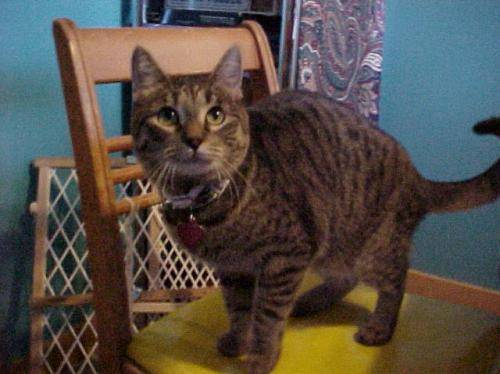

In [4]:
#Mostrando imagem
Image.open(animals_dataset["cats"][0])

### Preprocessamento do dataset

#### Redimensionando imagens

In [5]:
img_size = (200,200)
X, y = [], []
for animal, images in animals_dataset.items():
    for image in images:
        img = Image.open(image)
        resized_img = np.array(img.resize(img_size))
        
        if len(resized_img.shape) < 3: #Verificando se a imagem está em modo grayscale
            resized_img = np.array(Image.fromarray(resized_img).convert('RGB'))
            
        X.append(np.array(resized_img))
        y.append(animals_labels[animal])      

#### Normalizando valores dos píxels das images

In [6]:
X = np.array(X)/255
y = np.array(y)

#### Separando amostras de treino e de teste

In [7]:
#Importando Stratified K-Fold do sklearn
from sklearn.model_selection import StratifiedKFold

In [8]:
#Realizando a primeira separação entre set de treinamento e de teste com proporção 0.2 de teste.
skf = StratifiedKFold(n_splits=5)

#Obtendo indexadadores das amostras de treino e de teste
train_idx, test_idx = list(skf.split(X,y))[0][0], list(skf.split(X, y))[0][1]

#Aplicando indexadores às entradas e saidas
X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
X_test, y_test = X[test_idx].copy(), y[test_idx].copy()

### Rede Neural Convolucional

#### Aplicando Data augmentation e Dropout

In [9]:
#Definindo camada de data augmentation com rotação, zoom e flip aleatórios
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.08),
    layers.RandomFlip('horizontal')
  ]
)

In [10]:
num_classes = len(animals_labels)

model = Sequential([
    keras.Input(shape=(200,200,3)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train, y_train, epochs=30)   

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 353ms/step - accuracy: 0.5009 - loss: 1.4073
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step - accuracy: 0.6732 - loss: 0.6976
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 370ms/step - accuracy: 0.6785 - loss: 0.6753
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 374ms/step - accuracy: 0.6864 - loss: 0.6453
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 369ms/step - accuracy: 0.7097 - loss: 0.5920
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 370ms/step - accuracy: 0.7295 - loss: 0.5554
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 371ms/step - accuracy: 0.7572 - loss: 0.5431
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 366ms/step - accuracy: 0.7585 - loss: 0.5304
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 372ms/step - accuracy: 0.7909 - loss: 0.4761
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step - accuracy: 0.7825 - loss: 0.4770
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 372ms/step - accuracy: 0.8166 - loss: 0.4219
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 28

In [13]:
result = model.evaluate(X_test,y_test)
dict(zip(model.metrics_names, result))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7026 - loss: 0.9500


{'loss': 0.7338312864303589, 'compile_metrics': 0.7683333158493042}

#### Análise de Resultados

Pelos resultados observados, vemos que o modelo atual, mesmo não atingindo a mesma acurácia nos dados de treino como foi o caso do modelo sem a aplicação de métodos de regularização sendo treinado por menos épocas, conseguiu desempenhar melhor quanto aplicado aos dados de teste.

Assim, mesmo o tempo de treinamento tendo aumentado bastante, foi possível observar uma melhora considerável quanto a variabilidade e robustêz do modelo apenas com a adição das camadas de data augmentation e de dropout. 

De qualquer modo, para extrair o melhor da rede neural convolucional para tal tarefa, seria necessário um trabalho mais extenso de busca dos hyperparâmetros mais adequados para tornar o modelo mais generalizado e preciso.

#### Salvando modelo treinado

In [14]:
# DESCOMENTE ESSA SEÇÃO PARA SALVAR MODELO TREINADO
import pickle

pick = open('../resultados/cnn_model_with_regularization.sav', 'wb')
pickle.dump(model,pick)
pick.close()

# DESCOMENTE ESSA SEÇÃO PARA IMPORTAR MODELO PRÉ-TREINADO
# pick = open('svc_model.sav', 'rb')
# model = pickle.load(pick)
# pick.close()